## LOAD DỮ LIỆU

In [2]:
xpath_coco = '../input/cocopersonsegmentation/train2017_new'
ypath_coco = '../input/cocopersonsegmentation/train2017_ann'
x_test_path = '../input/cocopersonsegmentation/val2017_new'
y_test_path = '../input/cocopersonsegmentation/val2017_ann'

In [3]:
input_img_paths_coco = sorted([os.path.join(xpath_coco, fname) for fname in os.listdir(xpath_coco)])
target_img_paths_coco = sorted([os.path.join(ypath_coco, fname) for fname in os.listdir(ypath_coco)])

In [4]:
input_img_val_paths_coco = sorted([os.path.join(x_test_path, fname) for fname in os.listdir(x_test_path)])
target_img_val_paths_coco = sorted([os.path.join(y_test_path, fname) for fname in os.listdir(y_test_path)])

In [5]:
print(f'Độ dài input train: {len(input_img_paths_coco)}, Độ dài target train: {len(target_img_paths_coco)}')
print(f'Độ dài input validation: {len(input_img_val_paths_coco)}, Độ dài target validation: {len(target_img_val_paths_coco)}')

In [6]:
for input_path, target_path in zip(input_img_paths_coco[:4], target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

In [7]:
for input_path, target_path in zip(input_img_val_paths_coco[:4], target_img_val_paths_coco[:4]):
    print(input_path, "|", target_path)

In [8]:
import matplotlib.pyplot as plt

In [9]:
n_images = 5
for i in np.random.randint(0,len(input_img_paths_coco),n_images):
    fig = plt.figure(figsize=(12,6))
    fig.tight_layout()

    plt.subplot(1,2,1)
    img = plt.imread(input_img_paths_coco[i])
    plt.imshow(img)
    plt.title('Image')

    plt.subplot(1,2,2)
    img = plt.imread(target_img_paths_coco[i])
    plt.imshow(img)
    plt.title('Mask')
    plt.show()
    print()

## CHUẨN BỊ DỮ LIỆU TRAINING

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

In [11]:
class Data_Generator(tf.keras.utils.Sequence):
    def __init__(self,batch_size,img_size,input_img_path,target_img_path):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
    def __len__(self):
        return len(self.target_img_path) // self.batch_size
    def __getitem__(self,idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_path[i : i + self.batch_size] 
        batch_target_img_paths = self.target_img_path[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)                                #(256,256)
            img = np.array(img)/255
            x[j] = img
        
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2) 
        return x, y

In [12]:
batch_size = 32
img_size = (256,256)
train_gen = Data_Generator(batch_size, img_size, input_img_paths_coco, target_img_paths_coco)
val_gen = Data_Generator(batch_size, img_size, input_img_val_paths_coco, target_img_val_paths_coco)
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

## XÂY DỰNG KIẾN TRÚC MÔ HÌNH - 1

In [13]:
from tensorflow.keras import layers

In [14]:
def downblock(filters, filter_size, previous_layer):
    x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.Activation("relu")(x)
    p = layers.MaxPooling2D(2)(x)

    return x,p
 
def bottleneck(filters, filter_size, previous_layer):
    x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(.5)(x)
    x = layers.Conv2D(filters, filter_size, padding="same")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat):
    x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
    concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation

    x = layers.Conv2D(filters, filter_size, padding="same")(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.Activation("relu")(x)

    return x

In [15]:
input_layer = layers.Input(shape = img_size + (3,))
 
conv1, pool1 = downblock(32, 3, input_layer)
conv2, pool2 = downblock(64, 3, pool1)
conv3, pool3 = downblock(128, 3, pool2)
conv4, pool4 = downblock(256, 3, pool3)
 
conv5 = bottleneck(512,3,pool4)

upconv1 = upblock(256, 3, conv5, conv4) 
upconv2 = upblock(128, 3, upconv1, conv3)
upconv3 = upblock(64, 3, upconv2, conv2)
upconv4 = upblock(32, 3, upconv3, conv1)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model = tf.keras.Model(input_layer, output_layer)
model.summary()

In [16]:
tf.keras.utils.plot_model(model, 'mohinh.jpg', show_shapes=True, show_layer_names=True)

## TRAINING MÔ HÌNH

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]) 

In [18]:
filepath = "model_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
callbacks = [checkpoint]

In [19]:
epochs = 1
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

## VẼ TRỰC QUAN LOSS,ACCURACY,IOU

In [27]:
model_history.history

In [28]:
history = {'loss': [0.2582,0.1537,0.1354],
           'accuracy': [0.8925,0.9363,0.9443],
           'mean_io_u': [0.4290,0.4291,0.4288],
           'val_loss': [0.2502,0.2566,0.2920],
           'val_accuracy': [0.8997,0.9046,0.9030],
           'val_mean_io_u': [0.4162,0.4162,0.4162]
}

In [29]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_iou = history['mean_io_u']
val_iou = history['val_mean_io_u']

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yticks(np.arange(0, .5,.05))
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0,1.1,.1))
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_io_u')
plt.plot(val_iou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u')
plt.yticks(np.arange(0,1,.05))
plt.legend()
plt.show()

## CHÈN BACKGROUND VÀO

In [1]:
import seaborn as sns
import os,cv2
from skimage import io

In [43]:
def ploting(imgpath, maskpath):
    plt.figure(figsize=(12,4))

    im = io.imread(imgpath)
    im = cv2.resize(im,img_size)
    im = np.array(im)/255

    plt.subplot(1,3,1)
    plt.title('Original')
    plt.imshow(im)

    im = im.reshape((1,)+im.shape)
    im.shape

    pred = model.predict(im)

    p = pred.copy()
    p = p.reshape(p.shape[1:-1])

    p[np.where(p>.2)] = 1
    p[np.where(p<.2)] = 0

    im = io.imread(imgpath)
    im = cv2.resize(im,img_size)
    im = np.array(im)

    im[:,:,0] = im[:,:,0]*p 
    im[:,:,0][np.where(p!=1)] = 247
    im[:,:,1] = im[:,:,1]*p 
    im[:,:,1][np.where(p!=1)] = 231
    im[:,:,2] = im[:,:,2]*p
    im[:,:,2][np.where(p!=1)] = 230

    plt.subplot(1,3,2)
    plt.imshow(im)

    if maskpath:
        plt.subplot(1,3,3)
        mask = io.imread(maskpath)
        plt.imshow(mask)

        plt.show()

In [44]:
n_images = 5
for i in np.random.randint(0,len(input_img_val_paths_coco),n_images):
      ploting(input_img_val_paths_coco[i], target_img_val_paths_coco[i])

# LOAD WEIGHT - UNET

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,MaxPooling2D,Dropout,concatenate,UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model

In [2]:
input_size = (256,256,3)
inputs = Input(input_size)

#Encoder
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)


#Decoder
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs, conv10)

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 12  0          ['conv2d_18[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 12  0           ['conv2d_1[0][0]',               
                                8)                                'conv2d_19[0][0]']              
                                                                                                  
 conv2d_20

In [4]:
model.load_weights('../weights/weights_unet/model_epoch_10_val_loss_0.151205.h5')

# LOAD WEIGHT - VGG16+UNET

[Posts](https://saifgazali.medium.com/cell-nuclei-segmentation-using-vgg16-unet-and-double-unet-eafb65bb959a)

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input,VGG16
from tensorflow.keras.applications import InceptionV3

In [6]:
def conv_block(inputs,num_filters):
    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    x = Conv2D(num_filters,3,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    return x

In [7]:
def define_decoder(inputs,skip_layer,num_filters):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    x = Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same',kernel_initializer=init)(inputs)  
    g = tf.keras.layers.Concatenate()([x,skip_layer])
    g = conv_block(g,num_filters)
    return g

In [8]:
def vgg16_unet(input_shape):
    inputs = Input(shape=input_shape)
    #encoder
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)  
    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output  
    s3 = vgg16.get_layer('block3_conv3').output  
    s4 = vgg16.get_layer('block4_conv3').output    
    b1 = vgg16.get_layer('block5_conv3').output 
  
  # Decoder Block
    d1 = define_decoder(b1,s4,512)
    d2 = define_decoder(d1,s3,256)
    d3 = define_decoder(d2,s2,128)
    d4 = define_decoder(d3,s1,64)  #output layer
    outputs = Conv2D(1,1,padding='same',activation='sigmoid')(d4)
    model = Model(inputs,outputs)
  
    return model

In [35]:
model_vgg_unet = vgg16_unet(input_shape = (256,256,3))
model_vgg_unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

 activation_19 (Activation)     (None, 64, 64, 256)  0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_transpose_10 (Conv2DTra  (None, 128, 128, 12  131200     ['activation_19[0][0]']          
 nspose)                        8)                                                                
                                                                                                  
 concatenate_14 (Concatenate)   (None, 128, 128, 25  0           ['conv2d_transpose_10[0][0]',    
                                6)                                'block2_conv2[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)             (None, 128, 128, 12  295040      ['concatenate_14[0][0]']         
                                8)                                                                
          

In [36]:
model_vgg_unet.load_weights("../weights/weights_vgg_unet/256x256/model_epoch_3_val_loss_0.129597.h5")

# TEST 1

In [37]:
import seaborn as sns
import os,cv2
from skimage import io
import matplotlib.pyplot as plt

In [38]:

def ploting(model, imgpath, maskpath = None,img_size = (512,512),threshold = .85):
    plt.figure(figsize=(20,6))
 
    im = io.imread(imgpath)
    im = cv2.resize(im,img_size)
    im = np.array(im)
 
    plt.subplot(1,4,1)
    plt.title('Original Image')
    plt.imshow(im)
 

    #Dự đoán
    input_image = im/255
    input_image = input_image.reshape((1,)+input_image.shape)
 
    pred = model.predict(input_image)
    pred = pred.reshape(pred.shape[1:-1])
    
    
    #tập trung vào ngưỡng màu nhị phân
    p = pred.copy()
    p[np.where(p>threshold)] = 1
    p[np.where(p<threshold)] = 0

    
    #3 kênh màu, và chèn màu trắng vào
    img = im.copy() 
    img[:,:,0] = img[:,:,0]*p 
    img[:,:,0][np.where(p!=1)] = 0
    img[:,:,1] = img[:,:,1]*p 
    img[:,:,1][np.where(p!=1)] = 0
    img[:,:,2] = img[:,:,2]*p
    img[:,:,2][np.where(p!=1)] = 0
 
    plt.subplot(1,4,2)
    plt.imshow(p)
    plt.title('Predicted Mask')
  
    plt.subplot(1,4,3)
    plt.imshow(img)
    plt.title('Predicted Image')
 
    plt.show()

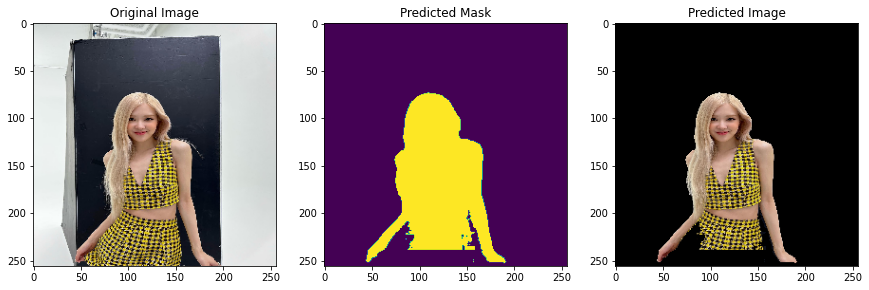

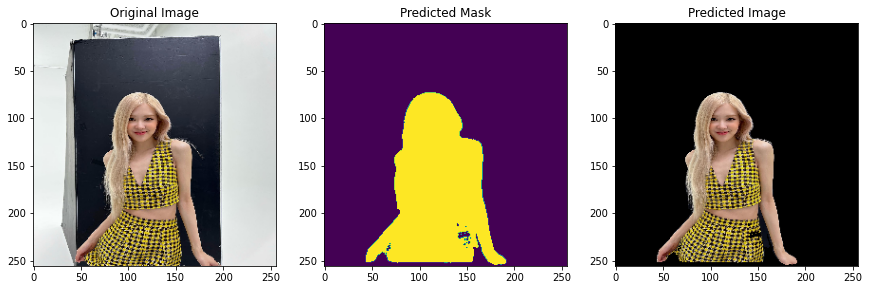

In [40]:
path_test = "../img_test/roses.jpg"
ploting(model,path_test,img_size=(256,256),threshold=0.75)

ploting(model_vgg_unet,path_test,img_size=(256,256),threshold=0.45)

# TEST 2

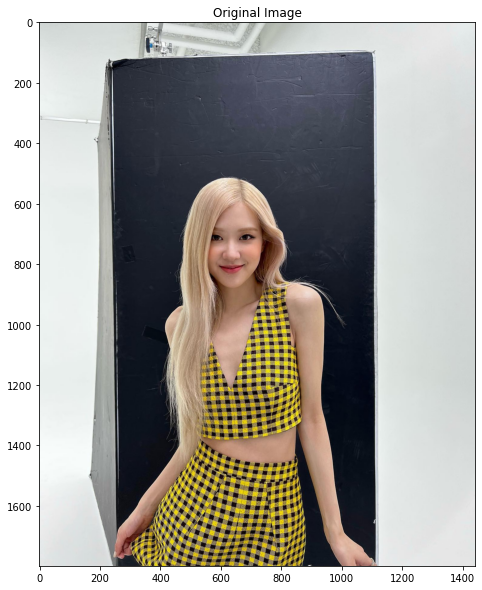

In [42]:
from PIL import Image
img_size = (256,256)
plt.figure(figsize=(35,10))
im = io.imread(path_test)
im = np.array(im)
plt.title('Original Image')
plt.imshow(im)

(1, 256, 256, 1)


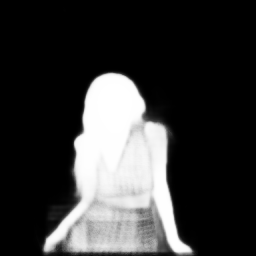

In [43]:
im = cv2.resize(im,img_size)
im = np.array(im)
input_image = im/255
input_image = input_image.reshape((1,)+input_image.shape)
pred = model_vgg_unet.predict(input_image)
print(pred.shape)
pred = pred.reshape(pred.shape[1:-1])
im = Image.fromarray(pred * 255).convert('RGB')
im

Original Image (1799, 1440, 3)
Mask Image (1799, 1440)
Image result (1799, 1440, 3)


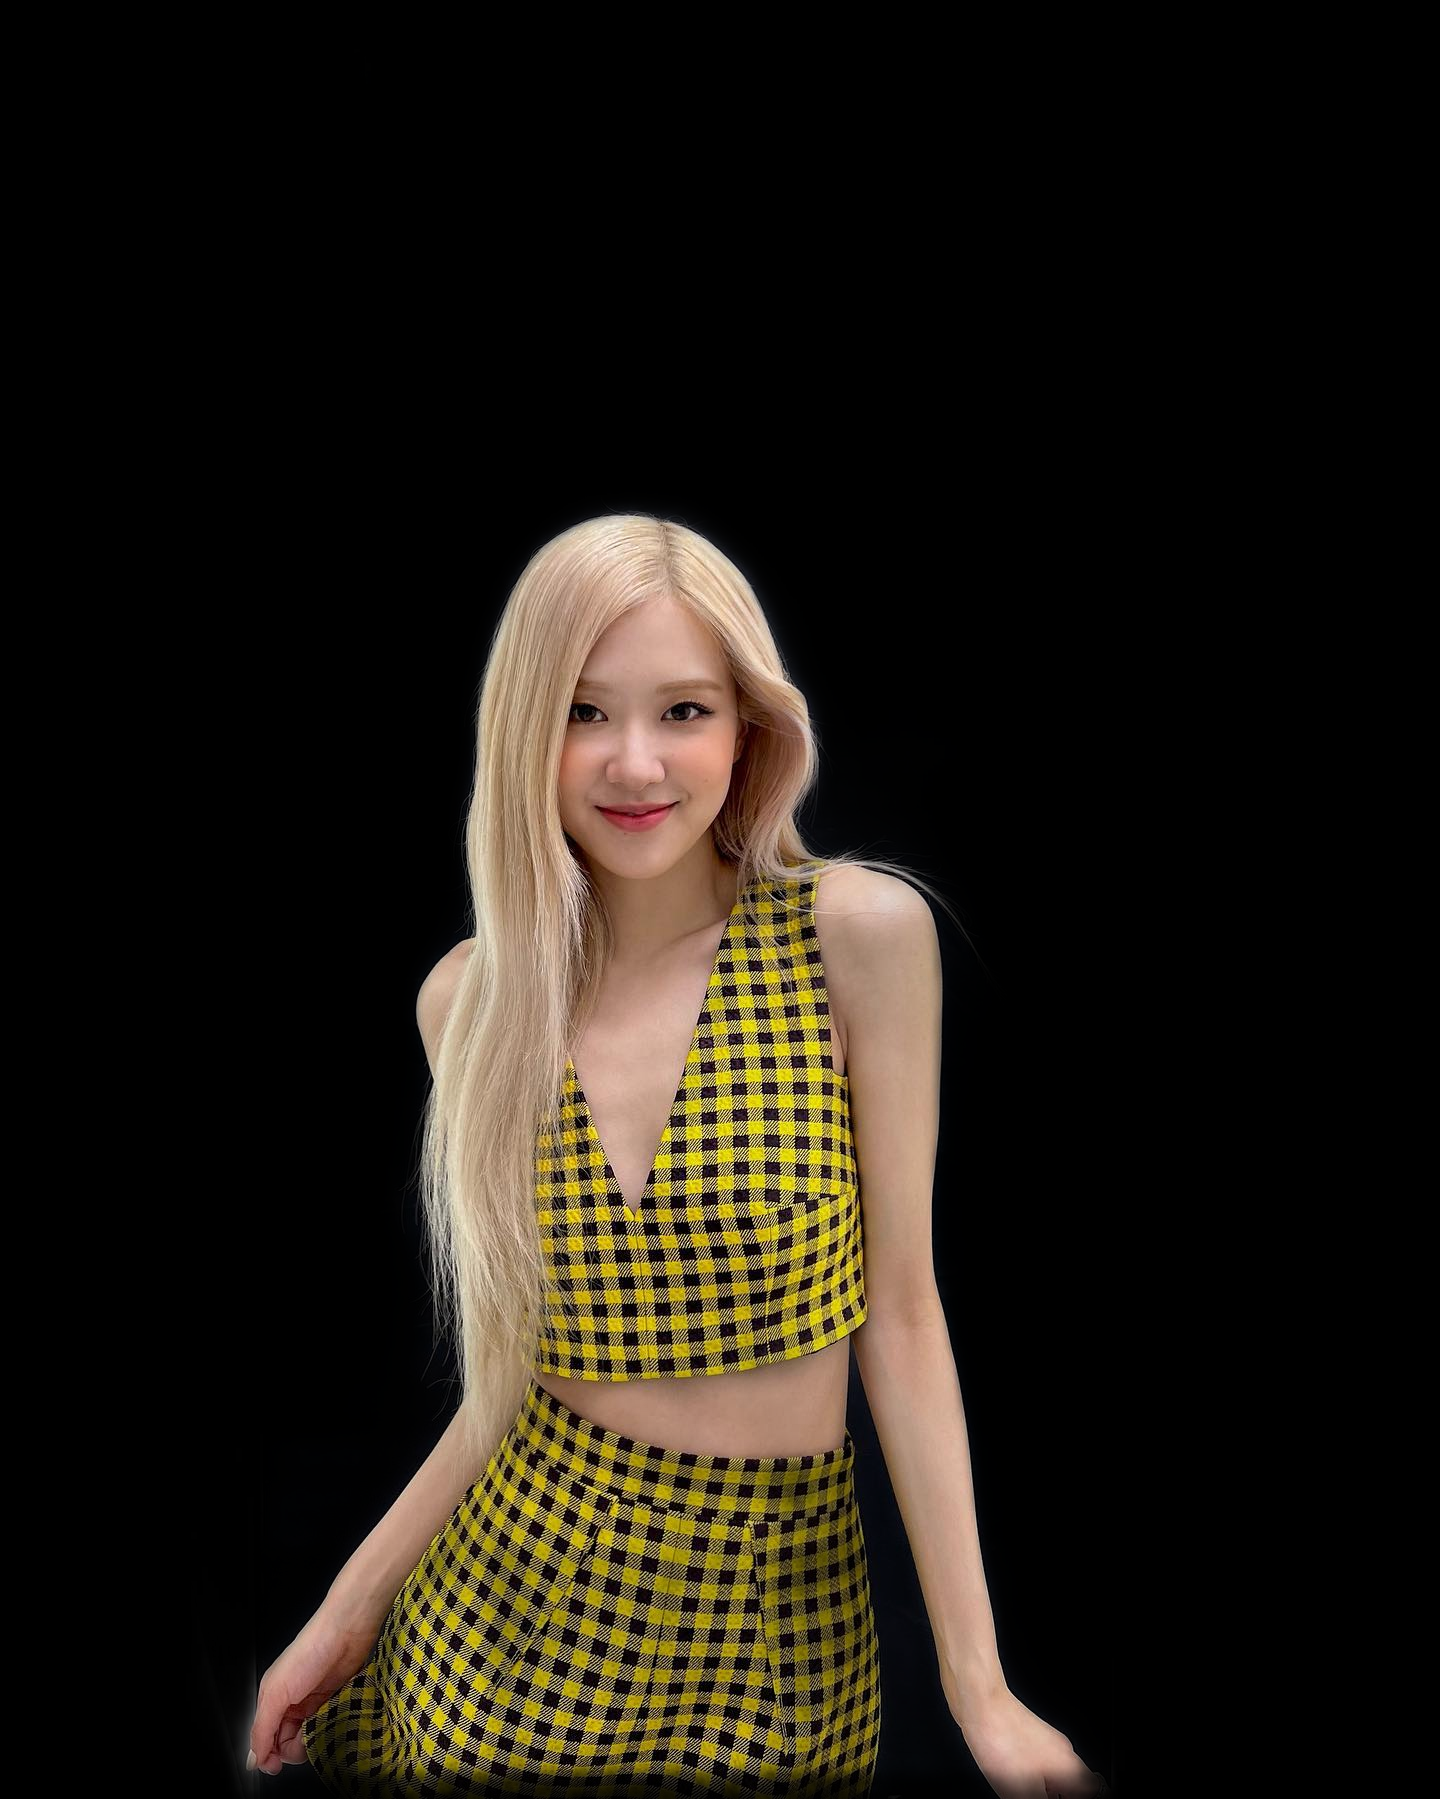

In [44]:
im_org = Image.open(path_test)
print('Original Image',np.array(im_org).shape)
mask = im.convert('L').resize((im_org.width, im_org.height))
print('Mask Image',np.array(mask).shape)
empty = Image.new("RGB", im_org.size, 0)
img = Image.composite(im_org, empty, mask)
print('Image result',np.array(img).shape)
img.save("../img_test/result_img2.jpg")
img

# TEST WITH WEBCAM

In [45]:
img_size = (256,256)
cap = cv2.VideoCapture('../img_test/rose.mp4')
threshold = 0.5
while True:
    ret,frame = cap.read()
    
    im = cv2.resize(frame,img_size)
    im = np.array(im)
    input_image = im/255
    input_image = input_image.reshape((1,)+input_image.shape)
    pred = model_vgg_unet.predict(input_image)

    pred = pred.reshape(pred.shape[1:-1])
    
    p = pred.copy()
    p[np.where(p>threshold)] = 1
    p[np.where(p<threshold)] = 0

    
    #3 kênh màu, và chèn màu trắng vào
    img = im.copy() 
    img[:,:,0] = img[:,:,0]*p 
    img[:,:,0][np.where(p!=1)] = 0
    img[:,:,1] = img[:,:,1]*p 
    img[:,:,1][np.where(p!=1)] = 0
    img[:,:,2] = img[:,:,2]*p
    img[:,:,2][np.where(p!=1)] = 0
    
    
    cv2.imshow('Video', img)

    # Break gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()